In [1]:
# Data preprocessing
import numpy as np
import pandas as pd
import nibabel as nib # common way of importing nibabel
import cv2
# !pip install nilearn
import nilearn as nil
import seaborn as sns
import matplotlib.pyplot as plt
import nilearn as nil
from nilearn.image import math_img
from scipy.ndimage import binary_dilation
sns.set()
import PIL
from PIL import ImageOps
import os
import imageio
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.transform as skTrans
import scipy.ndimage as ndi
from nibabel.processing import resample_from_to
from nilearn.plotting import plot_roi, plot_epi, plot_anat, plot_img
from nilearn.image import crop_img, math_img
from skimage import filters, io, morphology, color
from skimage.exposure import histogram,rescale_intensity
#modeling madules
import tensorflow as tf
import keras.backend as K
# from keras.utils import Sequence

# from tensorflow.keras.utils import plot_model
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, multiply
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as ppi_resnet
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as ppi_vgg
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
# from patchify import patchify, unpatchify 
# !pip install segmentation_models
import segmentation_models as sm
import sys
import random
import time
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from keras.models import load_model
from tensorflow.keras import utils as np_utils
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps 
from keras.applications.resnet import ResNet50


Segmentation Models: using `keras` framework.


In [2]:
# # Load the data from gdrive

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#parameters:
VOLUME_SLICES = 128
# VOLUME_START_AT =300
VOLUME_START_AT=60
VOLUME_SLICES=128
slice_w =180
IMG_SIZE=128
IMG_HEIGHT=128
IMG_WIDTH=128
batch_size = 1


# loading data and registration

In [4]:
# The Neuroimaging Informatics Technology Initiative (nifti)
# Fluid attenuated inversion recovery (FLAIR)

#=====image_alignment==============================================    
    
def image_alignment(img):
  """
  MRI image because of alignment on magnet and system is not the standard way to anlysing.
  they should be aligned neither direction or origin coordination according to standard way.
  return image
  """
#   t1_affine = img.affine #tells the position of the image array data in a reference space
  # central_voxel = np.array([img.shape[0]//2, img.shape[1]//2, img.shape[2]//2, 1])
  # center_scanner = t1_affine @ central_voxel
  # center_t1 = np.linalg.inv(t1_affine) @ center_scanner
  img_t1_resampled = resample_from_to(img, (img.shape[:3], t1_affine))#this command is the same implementation previous lines
  return img_t1_resampled

#=====equalization==============================================

def equalization(data, nbr_bins=256):
   """
   to make equalization of intensity on whole image to remove unbalanced brightness or darkness
   opencv is the another algorithm to work well.
   return array
   """
   #get image histogram
   imhist,bins = histogram(data.flatten(),nbr_bins)
   cdf = imhist.cumsum() #cumulative distribution function
   cdf = 255 * cdf / cdf[-1] #normalize
   #use linear interpolation of cdf to find new pixel values
   data1 = np.interp(data.flatten(),bins,cdf)
   data = data1.reshape(data.shape)
   return data 

#==================================================  
images = []
hdr = []
images_shape = []
images_data = []
images_index = []
affine = []
non_reshaped = []
files = []
df = pd.DataFrame()
masks=[]
mean = [] #to make alist to use in counting the 
#=====loading image ============================================== 
"""
MRI image is in nifti format so for loading data from image , just Nibabel library could get data from image.
any MRI image is included log file having the information about dimension, axis info.
any tissue in brain has its intensity so for masking bone and other extra tissue
to extract whole brain, it requires to find the threshold of intensity.
there are too many algorithm to do it. here otsu has been chosen.
return array
"""
dirs = os.listdir('../mri image/data/02')[:100]
for i, file in enumerate(dirs):
    mri_file = os.path.join('../mri image/data/02', file)
#     print(dirs)
#     print(mri_file)
    files.append(mri_file)
    img = nib.load(mri_file)
    data = img.get_fdata()
    t1_affine = img.affine
    images_data.append(data)
    hdr_ = img.header
    images.append(img)
    hdr.append(hdr_)
    affine.append(t1_affine)
#=====binary mask ============================================== 
#this part just one time would be done for extracting mask and saving for modeling.
#     data = image_alignment(img).get_fdata()#this function is really expensive, so it is better to be done in seperate process out of this loop. 
    #     img = equalization(data, nbr_bins=256)#this function has neot been used because on mask contarst had negative effect and needs to be imroved.
#     data = images_data[i][:,:,images_data[i].shape[0]//2-slice_w]
#     threshold  = filters.thresholding.threshold_otsu(data)
#     binary_mask = np.array(images_data[i]>=threshold*2.85, dtype=np.int8)
#     img_mask = nib.Nifti1Image(binary_mask, img.affine, img.header)
#     masks.append(binary_mask)
#     nib.loadsave.save(img_mask,'mask')#save mask file to use one time to be useable on the rest of the modeling and saving time and memory
#     plt.imshow(binary_mask[:,:, images_data[i].shape[0]//2-slice_w])
    # binary_mask.shape
    

In [33]:
print(images[0].header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 160 256 256   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.        0.9999998 1.0351562 1.0351562 6.        0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=3.6e+002;Time=120949.080;phase=1'
aux_file        : b'imgComments'
qform_code      : scanner
sform_code      : aligned
quatern_b       : -0.00034901497
quatern_c       : 0.012075871
quatern_d       : 0.0288880

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


<Figure size 720x720 with 0 Axes>

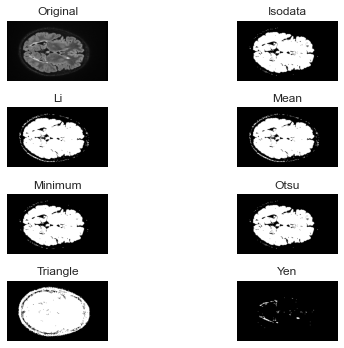

In [59]:
fig = plt.figure(figsize=(10, 10))#to show all threshold for one image, Otsu is the best for this project to have the mask
threshold  = filters.thresholding.try_all_threshold(images_data[12][:,:,images_data[12].shape[0]//2-slice_w])

(152, 256, 256)

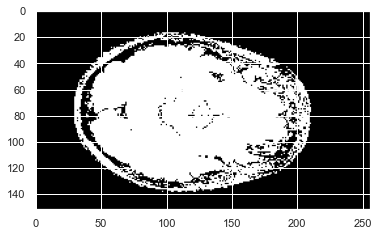

In [61]:
# colormask = np.zeros(images[0].shape, dtype=np.uint8)
# arr = images[0][:,:,images_data[0].shape[0]//2-slice_w].shape, dtype=np.uint8) 
data = images_data[0][:,:,images_data[12].shape[0]//2-slice_w]
threshold  = filters.thresholding.threshold_otsu(data)
binary_mask = np.array(images_data[12]>=threshold, dtype=np.int8)
plt.imshow(binary_mask[:,:,140], cmap='gray')
binary_mask.shape

Text(0.5, 1.0, 'mask : sagital slice in middle')

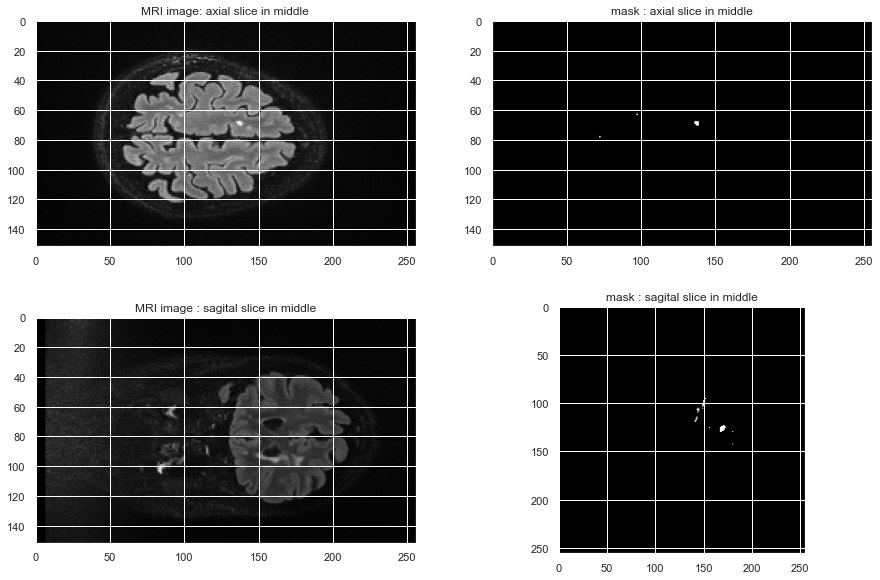

In [69]:
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
ax1.imshow(images_data[12][:,:, images_data[30].shape[0]//2-slice_w], cmap='gray')#indexing for imagees_data is i, slice is almost the axial view in middle
ax2.imshow(images_data[13][:,:, images_data[31].shape[0]//2-slice_w], cmap='gray')#indexing for mask is i+1

ax3.imshow(images_data[12][:,images_data[12].shape[0]//2-slice_w, : ], cmap='gray')#indexing for imagees_data is i, slice is almost the axial view in middle
ax4.imshow(images_data[13][images_data[13].shape[0]//2-slice_w,:, :] , cmap='gray')#indexing for mask is i+1

ax1.set_title('MRI image: axial slice in middle')
ax2.set_title('mask : axial slice in middle')
ax3.set_title('MRI image : sagital slice in middle')
ax4.set_title('mask : sagital slice in middle')

C:\Users\zmaso\anaconda3\lib\site-packages\nilearn\image\resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\zmaso\anaconda3\lib\site-packages\nilearn\image\resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
C:\Users\zmaso\anaconda3\lib\site-packages\nilearn\image\resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


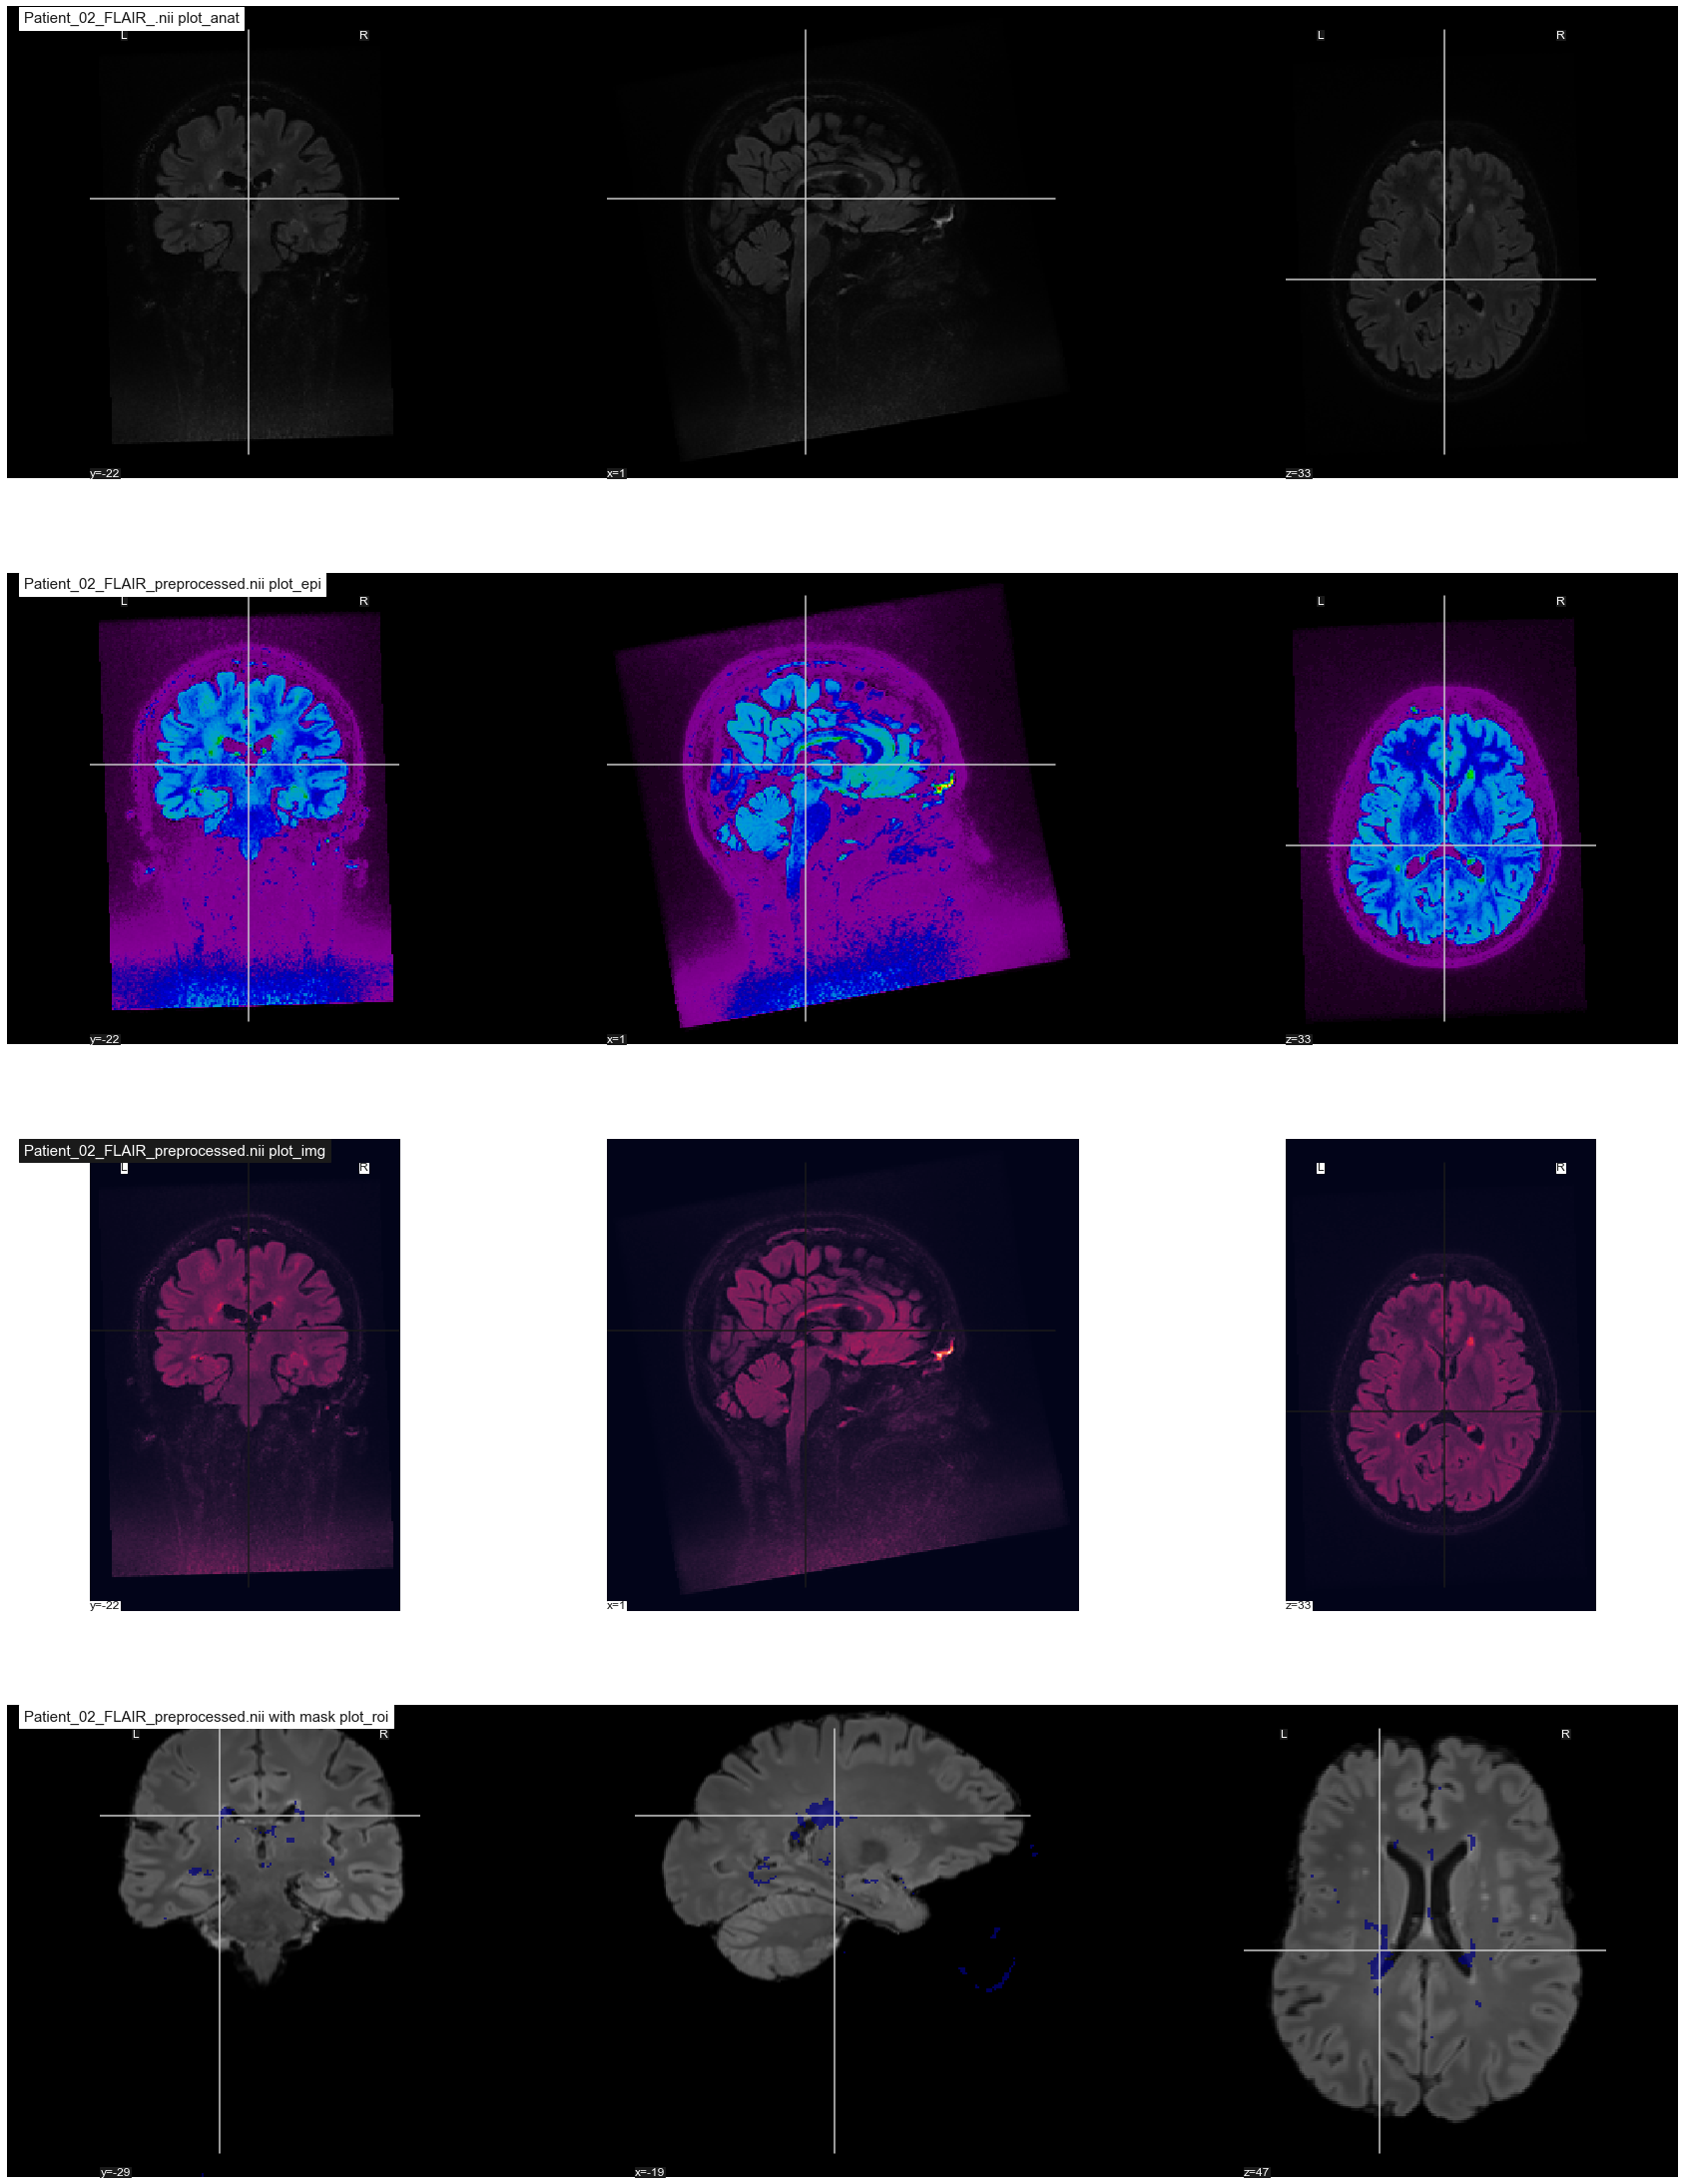

In [64]:
# niflair = nil.image.load_img('../mri image/data/02/FLAIR (0-7).nii')
# nimask = nil.image.load_img('../mri image/data/02/FLAIR (0-7)_mask.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


plot_anat(images[12],
                title='Patient_02_FLAIR_.nii plot_anat',
                axes=axes[0])

plot_epi(images[12],
               title='Patient_02_FLAIR_preprocessed.nii plot_epi',
               axes=axes[1])#angle in image is because of adjusting the affine

plot_img(images[12],
               title='Patient_02_FLAIR_preprocessed.nii plot_img',
               axes=axes[2])

plot_roi(images[13], 
               title='Patient_02_FLAIR_preprocessed.nii with mask plot_roi',
               bg_img=niflair, 
               axes=axes[3])

plt.show()

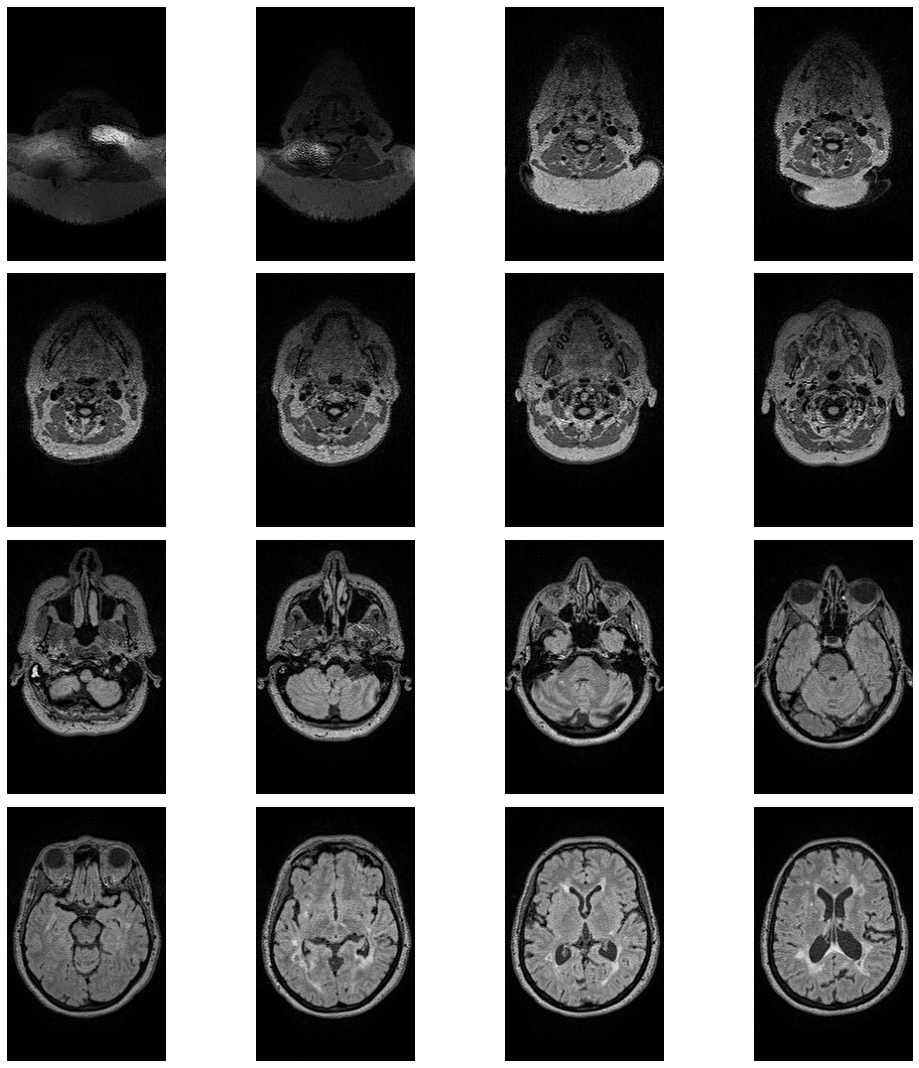

In [67]:
# Plot a series of slices
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = images_data[0].shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[15, 15])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(images_data[0][:,: , img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

# Dataset generation

In [5]:
# defining evaluation parameters.
"""
For evaluation of segmentation, the best parameters would be Dice Coefficient or Mean IOU
showing the percenrage of covering the predicted segment and true segment as true_y. 
to read more: #https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
"""

def dice_coef(y_true, y_pred, smooth=0.1):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)



#this the pre-defined in library hasnot been used in this project insteed of this function defined below.
def iou_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
        union = K.sum(y_true[:,:,:,1])+K.sum(y_pred[:,:,:,1])-intersection
        iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
        return iou


In [6]:
# making a list of indexes for shuffling nordef to use in datagenerator
PATH = '../mri image/data/02'

dirs = os.listdir(PATH)
def pathListIntoIds(dirs):
    x = []
    for i, file in enumerate(dirs):
        if file!= '.ipynb_checkpoints':
            mri_file = os.path.join('../mri image/data/02', file)
            x.append(mri_file.split('\\')[-1])#can not use split bc of (+1) ../mri image/data/02\flair (10).nii  
    return x

train_and_test_ids = pathListIntoIds(dirs);#index directory 

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


In [7]:
# this class is a way  : the network will only train once on each sample per epoch which is not the case with generators.

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size =1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

        
 #   Number of batch in the Sequence.
    def __len__(self):
        
        return int(np.floor(len(self.list_IDs) / self.batch_size))

 #    Gets batch at position index, return a complete batch .   
    def __getitem__(self, index):

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]
#         print(Batch_ids)

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    
    # modify the dataset between epochs, each time,shuffle  and build the new train batch 

    def on_epoch_end(self):

        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
                
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
   
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(PATH, i)
#             print(c, i)
            img_name = i.split('_')
            if img_name[-1]!='mask ':
            # data_path = os.path.join(case_path, f'FLAIR {i}.nii');
                flair = nib.load(case_path).get_fdata()
           
            mask_path = os.path.join(PATH, i);
            seg = nib.load(mask_path).get_fdata()
       
            for j in range(VOLUME_SLICES):
                try:
                    X[j] [c] = cv2.resize(flair[:,:,j], (IMG_SIZE, IMG_SIZE));
 
                except:
                    pass
                  
                try:
                    y[j ][c] = seg[:,:,j];
                except:
                    pass

        # Generate masks
        y[y==0] = 0;
        
        mask = tf.one_hot(y, 2);
        y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
#         y = image_datagen.flow(y)
        return X/(np.max(X)+.0001), y
    

        
training_generator = DataGenerator(train_ids) 
 
valid_generator = DataGenerator(val_ids) 

test_generator = DataGenerator(test_ids)


No handles with labels found to put in legend.


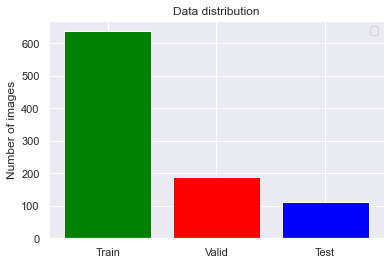

In [8]:
# show number of data for each dir 
def data_distribution():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
   
data_distribution()

# training on model

In [9]:
model_history = pd.DataFrame()
seg_model_names = []
Backbones = []
activations = []

def seg_model(training_generator, validation_generator, test_generator,backbone, model,
          input_shape , n_classes, activation, 
          learning_rate, batch_size, epochs ):

#=========model architecture======================================================    
    print('=================model architecture========================================================')
    #to know more about resnet implementation: https://wandb.ai/cayush/resnet/reports/Exploring-ResNets-With-W-B--Vmlldzo2NDc4NA
    BACKBONE = backbone
    preprocess_input = sm.get_preprocessing(BACKBONE)
    #create model
    model = sm.Unet(BACKBONE,
                       classes=n_classes,
                       activation=activation,
                       encoder_weights=None,
                       encoder_freeze=True,
                       input_shape = input_shape)

    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
                  metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=n_classes), dice_coef_MS, dice_coef] )#,iou_coef
    file_name = '../notebooks/model.h5'
    config =model.save(file_name)
    model = keras.models.load_model(file_name, custom_objects={ 
#                                                    "MeanIoU" : iou_coef,#not used bc of error
                                                   "dice_coef": dice_coef,
                                                   "dice_coef_MS" : dice_coef_MS
                                                    }, compile=False)
#=========modeled by saved weight===========================================================
    print('Fitting')
    x = model.input
    predictions = Dense(2, activation= activation)(x)
    model = keras.models.Model(inputs = model.input, outputs = predictions)
    # compile keras model with defined optimozer, loss and metrics
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
                  metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=n_classes), dice_coef,dice_coef_MS] )
    model.summary()

#=======fitting======================================================
    print('=================Fitting========================================================')
#     best_model = ModelCheckpoint(model, monitor='val_acc', mode='max',verbose=3, save_best_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger('history.csv')]

    history = model.fit(training_generator, epochs=epochs,  validation_data=valid_generator, callbacks=callbacks)

#======evaluation==========================================================================    
    print('=================Evaluation========================================================')
    model.evaluate(test_generator)
        # test_gen = ImageDataGenerator(rescale=1./255)
    # holdout = test_gen.flow_from_directory('data/test', target_size=(224, 224), class_mode='categorical', shuffle=False)
    predictions = model.predict(test_generator)
    # y_true = test_generator.labelsy_pred = np.array([np.argmax(predictions[i]) for i in range(predictions.shape[0])])
# mask = np.expand_dims(y_pred, axis=-1)
    # keras.preprocessing.image.array_to_img(mask)
    print('=================plotting========================================================')
    for item in ['loss', 'dice_coef' ]:
        plt.plot(history.history[item], label=item)
        plt.plot(history.history["val_" + item], label="val_" + item)
        plt.xlabel("Epochs")
        plt.ylabel(item)
        plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    

#================================================================================   

    """Quick utility to display a model's prediction."""
    i = np.random.choice(random_choice)
    mask = np.argmax(predictions[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = tf.keras.preprocessing.image.array_to_img(mask)
#     display(img)
        # Display input image
#     display(Image(filename=val_input_img_paths[i]))

    # Display ground-truth target mask
    # img = ImageOps.autocontrast(test_generator[i])
    # display(img)
    # Display mask predicted by our model
  # Note that the model only sees inputs at 150x150.
#=========dataFrame======================================================    
   
   # seg_model_names.append(model) 
   # Backbones.append(backbone)
   # activations.append(activation)
   # df = pd.read_csv('../notebooks/history.csv')
   # history = pd.concat([model_history, df] , axis=1)
   # name = f'{model}-{backbone}'
   # history.to_csv(name)

# run the model for different API s

In [3]:
n_classes=2
activation='softmax'
input_shape = (128, 128, 2)
epochs=20 
batch_size=batch_size
learning_rate=0.001
random_choice = range(150)
backbone =  'resnet50'
model = Unet
seg_model(training_generator, valid_generator, test_generator,backbone=backbone, model=model,
          input_shape = input_shape, n_classes=n_classes, activation=activation, 
          learning_rate=learning_rate, batch_size=batch_size, epochs=epochs  )



In [ ]:
n_classes=2
activation='softmax'
input_shape = (128, 128, 2)
epochs=20 
batch_size=batch_size
learning_rate=0.001
random_choice = range(150)
backbone =  'resnet50'
model = Linknet

seg_model(training_generator, valid_generator, test_generator,backbone=backbone, model=model,
          input_shape = input_shape, n_classes=n_classes, activation=activation, 
          learning_rate=learning_rate, batch_size=batch_size, epochs=epochs  )



In [42]:
n_classes=2
activation='softmax'
input_shape = (128, 128, 2)
epochs=20 
batch_size=batch_size
learning_rate=0.001
random_choice = range(150)
backbone =  'resnet50'
model = FPN

seg_model(training_generator, valid_generator, test_generator,backbone=backbone, model=model,
          input_shape = input_shape, n_classes=n_classes, activation=activation, 
          learning_rate=learning_rate, batch_size=batch_size, epochs=epochs  )

In [ ]:
n_classes=2
activation='softmax'
input_shape = (128, 128, 2)
epochs=20 
batch_size=batch_size
learning_rate=0.001
random_choice = range(150)
backbone =  'vgg19'
model = Unet

seg_model(training_generator, valid_generator, test_generator,backbone=backbone, model=model,
          input_shape = input_shape, n_classes=n_classes, activation=activation, 
          learning_rate=learning_rate, batch_size=batch_size, epochs=epochs  )

refrences:
[1]  MEHDI SADEGHIBAKHI, HAMIDREZA POURREZA, AND HAMIDREZA MAHYAR,"Multiple Sclerosis Lesions Segmentation Using Attention-Based CNNs in FLAIR Image," IEEE Trans. Biomed. Eng.VOLUME 10, 2022
[2]https://www.kaggle.com/code/yerramvarun/understanding-dice-coefficient

[3]https://www.kaggle.com/code/sasikumarg/eda-ms-lession-segmentation-on-resnet

[4]https://www.kaggle.com/code/mohamedmustafa/medical-image-segmentation-using-u-net-with-keras/notebook

[5]https://www.kaggle.com/code/bonhart/brain-mri-data-visualization-unet-fpn

